=== Data Partition Validation ===
Training period: 2019-01-08 to 2021-12-31
Testing period:  2022-01-01 to 2022-12-31
Training samples: 1,089
Testing samples:  365

Class distribution (Training):
PRECTOTCORR_binary
1    0.582185
0    0.417815
Name: proportion, dtype: float64

Training shapes - X: (1253, 15, 14), y: (1253,)
Test shapes - X: (350, 15, 14), y: (350,)


c:\Users\priya\main_rainfall_prediction\Rainfall_prediction\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 15, 64)         │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,441 (833.75 KB)

 Trainable params: 213,057 (832.25 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7804 - auc: 0.8383 - loss: 3.6698 - precision: 0.7873 - recall: 0.8753 - val_accuracy: 0.7610 - val_auc: 0.7280 - val_loss: 2.2537 - val_precision: 0.1556 - val_recall: 0.2414 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8017 - auc: 0.8711 - loss: 1.7547 - precision: 0.8178 - recall: 0.8578 - val_accuracy: 0.8606 - val_auc: 0.8471 - val_loss: 1.2164 - val_precision: 0.3846 - val_recall: 0.3448 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8382 - auc: 0.9037 - loss: 0.9223 - precision: 0.8647 - recall: 0.8642 - val_accuracy: 0.7729 - val_auc: 0.8389 - val_loss: 0.9112 - val_precision: 0.3293 - val_recall: 0.9310 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8252 - auc: 0.8973 - loss: 0.6270 - precision: 0.8332 - recall: 0.8801 - val_accuracy: 0.8048 - val_auc: 0.8061 - val_loss: 0.7378 - val_pr

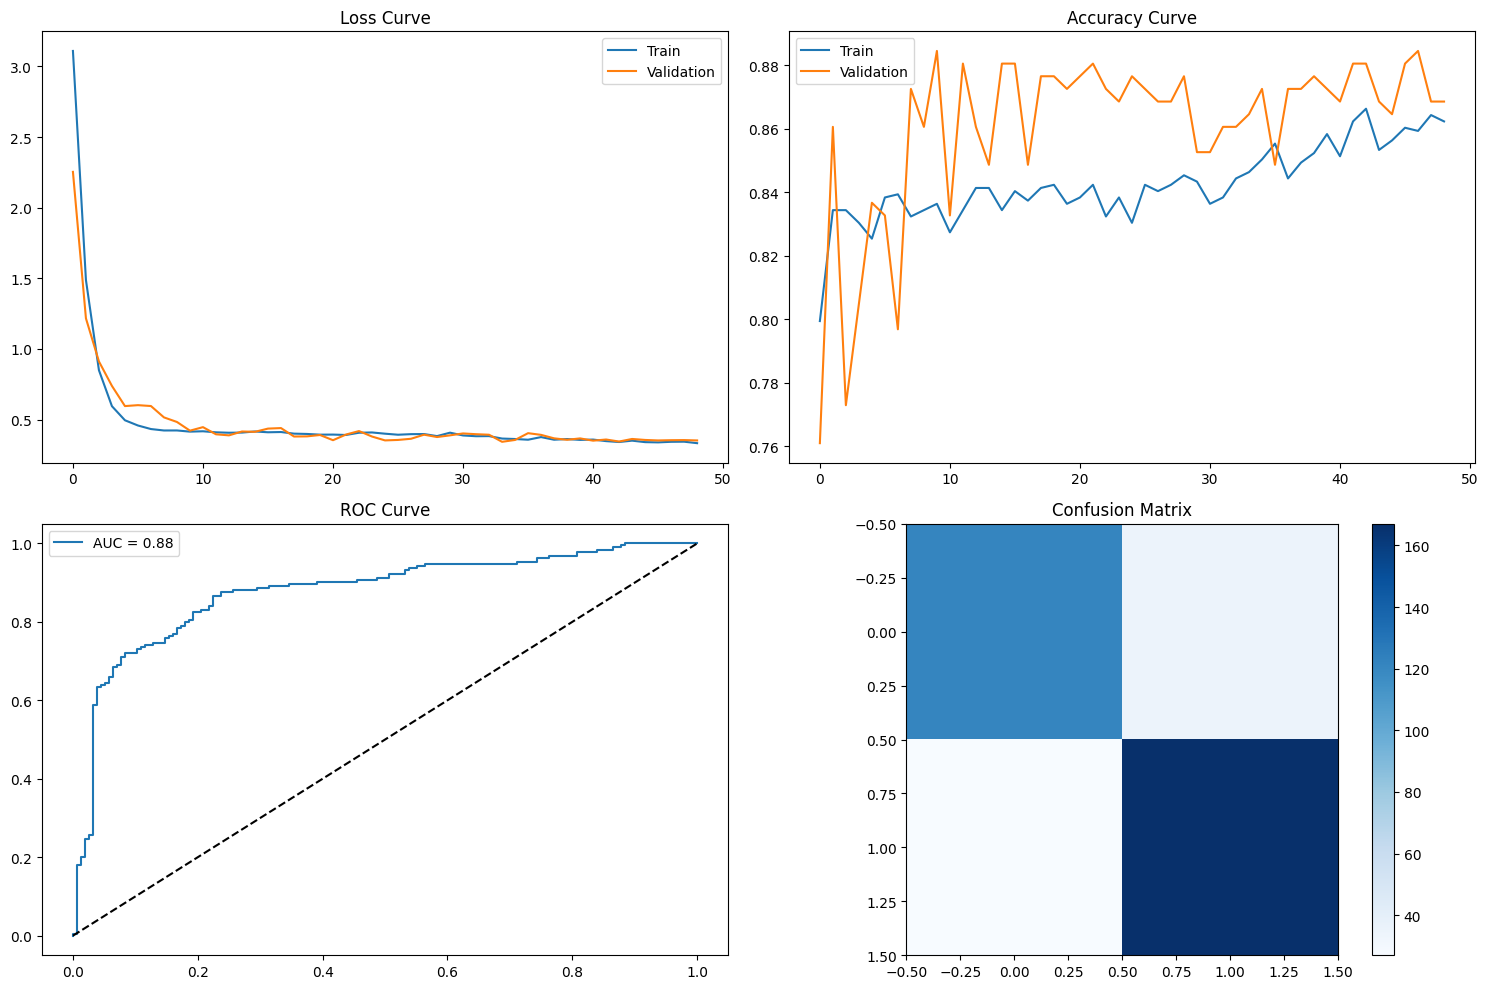

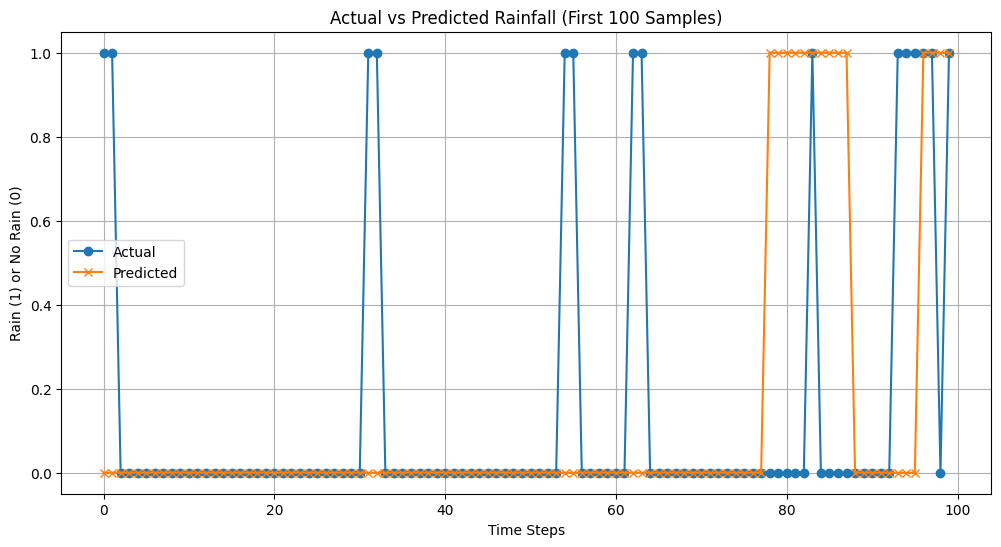


Next 7 Day Predictions:
Day 1: No Rain
Day 2: No Rain
Day 3: No Rain
Day 4: No Rain
Day 5: No Rain
Day 6: No Rain
Day 7: No Rain


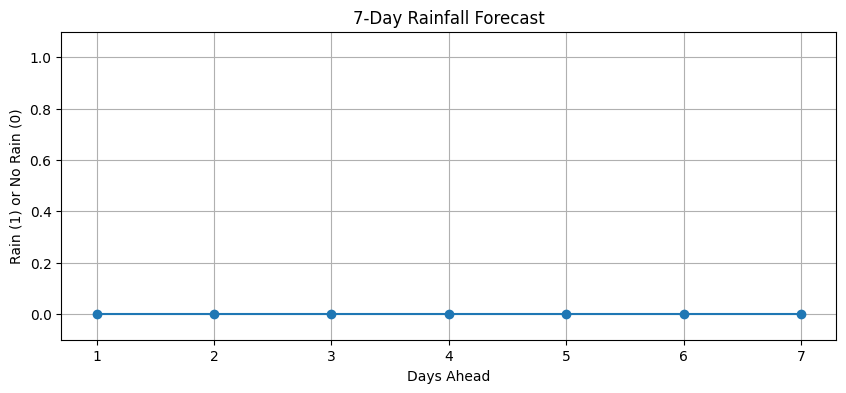

In [ ]:
# code for rainfall prediction in hyderabad using cnn+lstm
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                           accuracy_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve, auc)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, LSTM, 
                                   Dense, Dropout, Flatten, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow as tf

# Step 1: Load and Prepare Data
def load_and_prepare_data():
    try:
        df_2019 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\adilabad_2019.csv').assign(YEAR=2019)
        df_2020 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\adilabad_2020.csv').assign(YEAR=2020)
        df_2021 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\adilabad_2021.csv').assign(YEAR=2021)
        df_2022 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\adilabad_2022.csv').assign(YEAR=2022)
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Error loading CSV files: {e}")

    # Concatenate data
    full_df = pd.concat([df_2019, df_2020, df_2021, df_2022], ignore_index=True)
    
    # Data preprocessing
    required_cols = ['YEAR', 'MO', 'DY', 'PRECTOTCORR']  # Include PRECTOTCORR for clarity
    for col in required_cols:
        full_df[col] = pd.to_numeric(full_df[col], errors='coerce')
    full_df.dropna(subset=required_cols, inplace=True)

    full_df['datetime'] = pd.to_datetime(dict(year=full_df['YEAR'], month=full_df['MO'], day=full_df['DY']))
    full_df['DOY'] = full_df['datetime'].dt.dayofyear
    full_df['sin_DOY'] = np.sin(2 * np.pi * full_df['DOY'] / 365.25)
    full_df['cos_DOY'] = np.cos(2 * np.pi * full_df['DOY'] / 365.25)

    # Add lagged features
    full_df['PRECTOTCORR_lag1'] = full_df['PRECTOTCORR'].shift(1)
    full_df['PRECTOTCORR_lag3'] = full_df['PRECTOTCORR'].shift(3)
    full_df['PRECTOTCORR_lag7'] = full_df['PRECTOTCORR'].shift(7)

    # Calculate Sea Level Temperature
    elevation = 505.5  # Adilabad elevation in meters
    lapse_rate = 0.0065  # °C per meter
    full_df['SLT'] = full_df['TS'] + (lapse_rate * elevation)
    full_df.dropna(inplace=True)

    # Define features and target
    features = ['SLT', 'SLP', 'T2M', 'TS', 'T2M_MAX', 'T2M_MIN', 'RH2M', 'WS10M_MAX', 'WS10M_MIN',
                'sin_DOY', 'cos_DOY', 'PRECTOTCORR_lag1', 'PRECTOTCORR_lag3', 'PRECTOTCORR_lag7']
    full_df['PRECTOTCORR_binary'] = (full_df['PRECTOTCORR'] > 0).astype(int)
    target = 'PRECTOTCORR_binary'

    # Strict year-based split
    train_df = full_df[full_df['YEAR'].isin([2019, 2020, 2021])].copy()
    test_df = full_df[full_df['YEAR'] == 2022].copy()
    
    # Validate the split
    print("=== Data Partition Validation ===")
    print(f"Training period: {train_df['datetime'].min().date()} to {train_df['datetime'].max().date()}")
    print(f"Testing period:  {test_df['datetime'].min().date()} to {test_df['datetime'].max().date()}")
    print(f"Training samples: {len(train_df):,}")
    print(f"Testing samples:  {len(test_df):,}")
    print("\nClass distribution (Training):")
    print(train_df['PRECTOTCORR_binary'].value_counts(normalize=True))
    
    return train_df, test_df, features, target

# Step 2: Balance and Preprocess Data
def preprocess_and_balance_data(train_df, test_df, features, target):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[features])
    test_scaled = scaler.transform(test_df[features])

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    train_balanced, train_target = smote.fit_resample(train_scaled, train_df[target])
    
    # Create DataFrames
    train_balanced_df = pd.DataFrame(train_balanced, columns=features)
    train_balanced_df[target] = train_target
    
    test_scaled_df = pd.DataFrame(test_scaled, columns=features, index=test_df.index)
    test_scaled_df[target] = test_df[target]
    test_scaled_df['DOY'] = test_df['DOY']
    
    return train_balanced_df, test_scaled_df, scaler

# Step 3: Create Sequences
def create_sequences(data, features, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq_features = data[features].iloc[i:i+seq_length].values
        X.append(seq_features)
        y.append(data[target].iloc[i+seq_length])
    return np.array(X), np.array(y)

# Step 4: Build CNN-LSTM Model
def build_cnn_lstm_model(seq_length, n_features):
    model = Sequential([
        # CNN Part
        Conv1D(filters=64, kernel_size=3, activation='relu', 
               input_shape=(seq_length, n_features), padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # LSTM Part
        LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        LSTM(64, kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        
        # Output
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 
                          tf.keras.metrics.Precision(name='precision'),
                          tf.keras.metrics.Recall(name='recall'),
                          tf.keras.metrics.AUC(name='auc')])
    model.summary()
    return model

# Step 5: Train and Evaluate
def train_and_evaluate(seq_length=15):
    # Load and prepare data
    train_df, test_df, features, target = load_and_prepare_data()
    
    # Balance and preprocess
    train_balanced, test_scaled, scaler = preprocess_and_balance_data(train_df, test_df, features, target)
    
    # Create sequences
    X_train, y_train = create_sequences(train_balanced, features, target, seq_length)
    X_test, y_test = create_sequences(test_scaled, features, target, seq_length)
    
    print(f"\nTraining shapes - X: {X_train.shape}, y: {y_train.shape}")
    print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")

    # Build and train model
    model = build_cnn_lstm_model(seq_length, len(features))
    
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5)
    ]
    
    history = model.fit(X_train, y_train,
                        epochs=100,
                        batch_size=32,
                        validation_split=0.2,
                        callbacks=callbacks,
                        verbose=1)

    # Evaluate
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Metrics
    print("\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot results
    plot_results(history, y_test, y_pred_prob, y_pred)
    
    return model, scaler, test_scaled, features, target

def plot_results(history, y_test, y_pred_prob, y_pred):
    plt.figure(figsize=(15, 10))
    
    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss Curve')
    plt.legend()
    
    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy Curve')
    plt.legend()
    
    # ROC Curve
    plt.subplot(2, 2, 3)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()
    
    # Confusion Matrix
    plt.subplot(2, 2, 4)
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

    # Actual vs Predicted plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:100], label='Actual', marker='o')
    plt.plot(y_pred[:100], label='Predicted', marker='x')
    plt.title('Actual vs Predicted Rainfall (First 100 Samples)')
    plt.xlabel('Time Steps')
    plt.ylabel('Rain (1) or No Rain (0)')
    plt.legend()
    plt.grid()
    plt.show()

# Step 6: Make Predictions
def make_predictions(model, scaler, test_scaled, features, seq_length, days=7):
    last_sequence = test_scaled[features].iloc[-seq_length:].values
    predictions = []
    
    for _ in range(days):
        # Reshape for model input
        x = last_sequence.reshape(1, seq_length, len(features))
        # Predict
        pred = model.predict(x, verbose=0)[0][0]
        predictions.append(1 if pred > 0.5 else 0)
        # Update sequence
        new_row = last_sequence[-1].copy()
        new_row[-3] = pred  # Update lag1 feature
        last_sequence = np.vstack([last_sequence[1:], new_row])
    
    return predictions

# Main execution
if __name__ == "__main__":
    seq_length = 15
    model, scaler, test_scaled, features, target = train_and_evaluate(seq_length)
    
    # Make future predictions
    future_preds = make_predictions(model, scaler, test_scaled, features, seq_length)
    print("\nNext 7 Day Predictions:")
    for i, pred in enumerate(future_preds, 1):
        print(f"Day {i}: {'Rain' if pred == 1 else 'No Rain'}")
    
    # Plot predictions
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, 8), future_preds, 'o-')
    plt.title('7-Day Rainfall Forecast')
    plt.xlabel('Days Ahead')
    plt.ylabel('Rain (1) or No Rain (0)')
    plt.ylim(-0.1, 1.1)
    plt.grid()
    plt.show()


=== Data Partition Validation ===
Training years: [2019, 2020, 2021]
Testing year:   2022

Training period: 2019-01-08 to 2021-12-31
Testing period:  2022-01-01 to 2022-12-31

Training samples: 1,089
Testing samples:  365

Class distribution (Training):
PRECTOTCORR_binary
1    0.582185
0    0.417815
Name: proportion, dtype: float64

Class distribution (Testing):
PRECTOTCORR_binary
1    0.550685
0    0.449315
Name: proportion, dtype: float64

After SMOTE balancing:
PRECTOTCORR_binary
0    634
1    634
Name: count, dtype: int64

Final input shapes:
X_train: (1253, 15, 14), y_train: (1253,)
X_test:  (350, 15, 14), y_test:  (350,)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 15, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 15, 14)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 14)    │     30,222 │ add_5[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 15, 14)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 15, 14)    │          0 │ add_5[0][0],      │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 14)    │         28 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 15, 128)   │      1,920 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 15, 128)   │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 15, 14)    │      1,806 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 15, 14)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 14)    │         28 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 14)    │     30,222 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 15, 14)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 15, 14)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 14)    │         28 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 15, 128)   │      1,920 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 15, 128)   │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 15, 14)    │      1,806 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 15, 14)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_9[0][0]   

 Total params: 95,145 (371.66 KB)

 Trainable params: 95,145 (371.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5599 - auc: 0.5384 - loss: 1.7411 - precision: 0.6224 - recall: 0.6893 - val_accuracy: 0.1155 - val_auc: 0.7627 - val_loss: 1.9402 - val_precision: 0.1155 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6158 - auc: 0.6223 - loss: 1.6217 - precision: 0.6444 - recall: 0.8116 - val_accuracy: 0.8287 - val_auc: 0.7623 - val_loss: 1.5587 - val_precision: 0.2667 - val_recall: 0.2759 - learning_rate: 1.0000e-04
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7255 - auc: 0.7943 - loss: 1.4869 - precision: 0.7586 - recall: 0.8000 - val_accuracy: 0.8207 - val_auc: 0.8339 - val_loss: 1.4825 - val_precision: 0.3824 - val_recall: 0.8966 - learning_rate: 1.0000e-04
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7914 - auc: 0.8606 - loss: 1.3779 - precision: 0.8300 - recall: 0.8231 - val_accuracy: 0.8167 - val_auc: 0.7260 - val_loss:

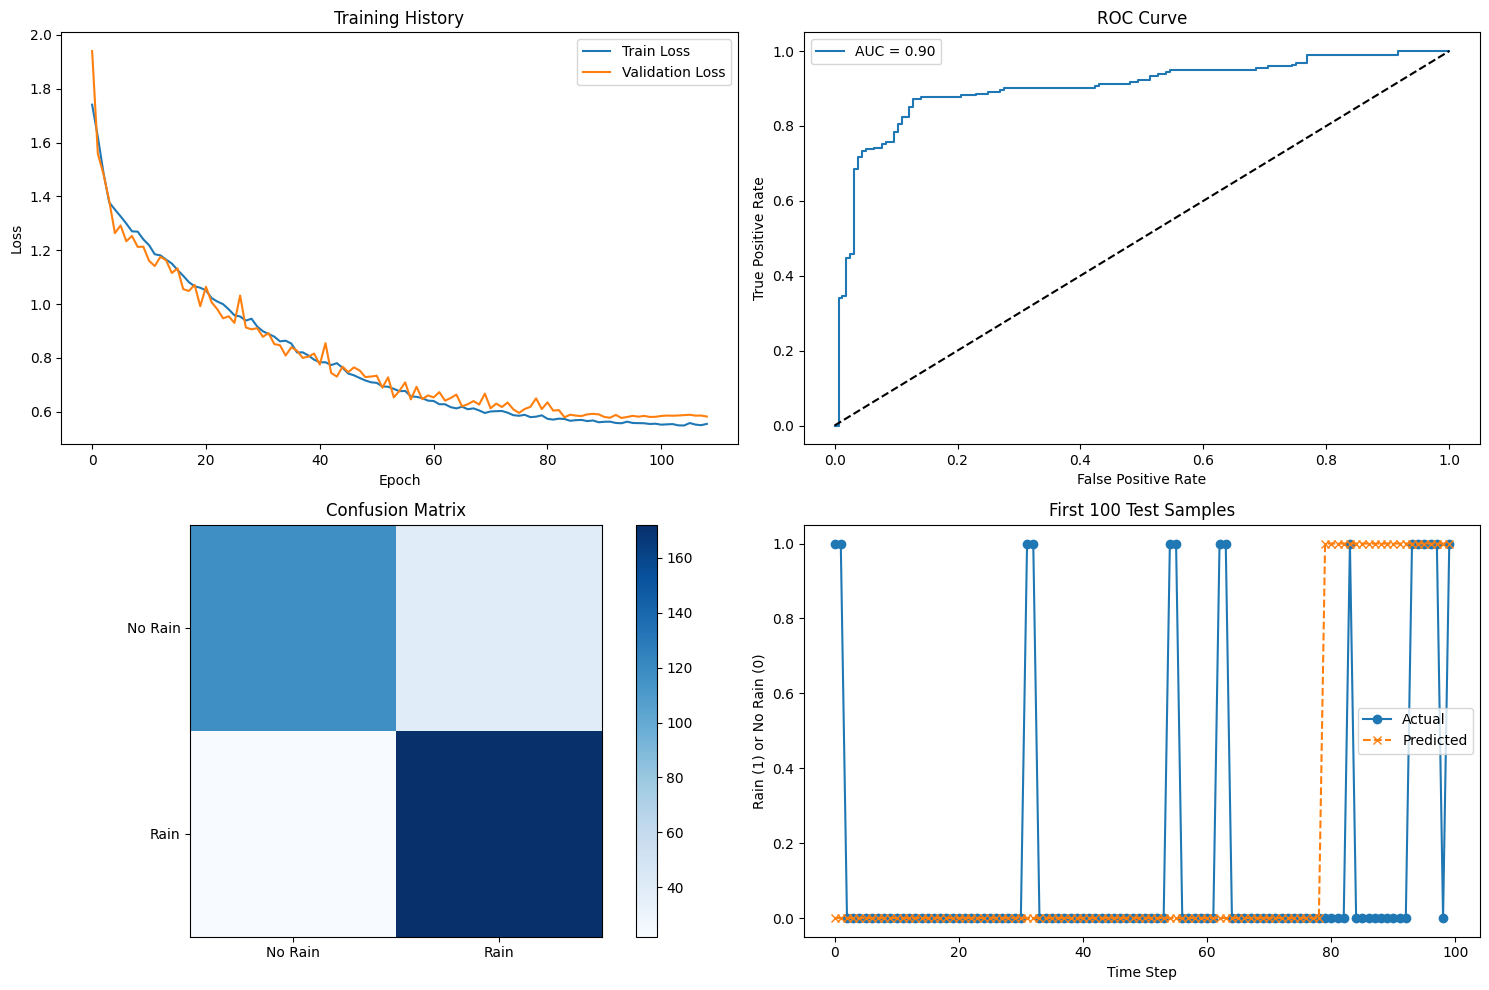


=== 7-Day Rainfall Forecast ===
Day 1: No Rain
Day 2: No Rain
Day 3: No Rain
Day 4: No Rain
Day 5: No Rain
Day 6: No Rain
Day 7: No Rain


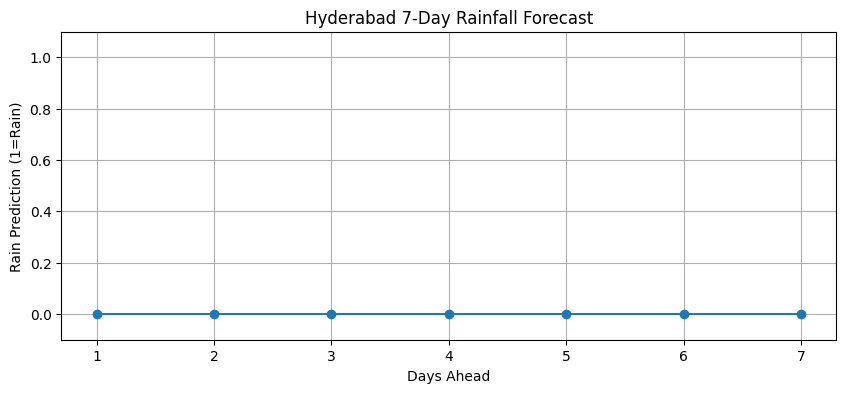

In [2]:
#for rainfaal hyderabad using transformer model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                           accuracy_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve, auc)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow as tf
# Modified version with enhanced validation checks

def load_and_prepare_data():
    try:
        # Load individual year datasets with explicit year tagging
         df_2019 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2019.csv').assign(YEAR=2019)
         df_2020 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2020.csv').assign(YEAR=2020)
         df_2021 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2021.csv').assign(YEAR=2021)
         df_2022 = pd.read_csv(r'C:\Users\priya\rainfall_prediction\Rainfall_prediction\datasets\hyderabad_2022.csv').assign(YEAR=2022)
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Error loading CSV files: {e}")

    # Combine data while preserving year information
    full_df = pd.concat([df_2019, df_2020, df_2021, df_2022], ignore_index=True)
    
    # Data quality checks
    required_cols = ['YEAR', 'MO', 'DY', 'PRECTOTCORR']
    missing_cols = [col for col in required_cols if col not in full_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Convert and clean data
    for col in required_cols:
        full_df[col] = pd.to_numeric(full_df[col], errors='coerce')
    full_df.dropna(subset=required_cols, inplace=True)

    # Create datetime and derived temporal features
    full_df['datetime'] = pd.to_datetime(dict(year=full_df['YEAR'], 
                                            month=full_df['MO'], 
                                            day=full_df['DY']))
    full_df['DOY'] = full_df['datetime'].dt.dayofyear
    full_df['sin_DOY'] = np.sin(2 * np.pi * full_df['DOY'] / 365.25)
    full_df['cos_DOY'] = np.cos(2 * np.pi * full_df['DOY'] / 365.25)

    # Create lagged precipitation features
    for lag in [1, 3, 7]:
        full_df[f'PRECTOTCORR_lag{lag}'] = full_df['PRECTOTCORR'].shift(lag)

    # Calculate Sea Level Temperature (Adilabad elevation: 254m)
    full_df['SLT'] = full_df['TS'] + (0.0065 * 505.5)
    full_df.dropna(inplace=True)

    # Define final feature set
    features = ['SLT', 'SLP', 'T2M', 'TS', 'T2M_MAX', 'T2M_MIN', 
               'RH2M', 'WS10M_MAX', 'WS10M_MIN',
               'sin_DOY', 'cos_DOY', 
               'PRECTOTCORR_lag1', 'PRECTOTCORR_lag3', 'PRECTOTCORR_lag7']
    target = 'PRECTOTCORR'
    full_df['PRECTOTCORR_binary'] = (full_df[target] > 0).astype(int)

    # Strict year-based splitting with validation
    train_years = [2019, 2020, 2021]
    test_year = 2022
    
    train_df = full_df[full_df['YEAR'].isin(train_years)].copy()
    test_df = full_df[full_df['YEAR'] == test_year].copy()
    
    # Additional validation checks
    if len(train_df) == 0:
        raise ValueError("No training data found for specified years")
    if len(test_df) == 0:
        raise ValueError("No test data found for specified year")
    
    # Check for temporal leakage
    max_train_date = train_df['datetime'].max()
    min_test_date = test_df['datetime'].min()
    if min_test_date <= max_train_date:
        raise ValueError(f"Temporal leakage detected! Latest training date ({max_train_date}) is after earliest test date ({min_test_date})")

    # Validate the split
    print("=== Data Partition Validation ===")
    print(f"Training years: {train_years}")
    print(f"Testing year:   {test_year}")
    print(f"\nTraining period: {train_df['datetime'].min().date()} to {train_df['datetime'].max().date()}")
    print(f"Testing period:  {test_df['datetime'].min().date()} to {test_df['datetime'].max().date()}")
    print(f"\nTraining samples: {len(train_df):,}")
    print(f"Testing samples:  {len(test_df):,}")
    print("\nClass distribution (Training):")
    print(train_df['PRECTOTCORR_binary'].value_counts(normalize=True))
    print("\nClass distribution (Testing):")
    print(test_df['PRECTOTCORR_binary'].value_counts(normalize=True))
    
    return train_df, test_df, features, 'PRECTOTCORR_binary'

# Rest of your code remains the same...
# Step 2: Balance and Scale Data
def preprocess_and_balance_data(train_df, test_df, features, target):
    # Initialize scaler and scale features
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[features])
    test_scaled = scaler.transform(test_df[features])

    # Apply SMOTE only to training data
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(train_scaled, train_df[target])
    
    # Create balanced DataFrames
    train_balanced = pd.DataFrame(X_resampled, columns=features)
    train_balanced[target] = y_resampled
    
    test_processed = pd.DataFrame(test_scaled, columns=features, index=test_df.index)
    test_processed[target] = test_df[target]
    test_processed['DOY'] = test_df['DOY']  # Preserve for sequence generation
    
    print("\nAfter SMOTE balancing:")
    print(train_balanced[target].value_counts())
    
    return train_balanced, test_processed, scaler

# Step 3: Create Time Sequences
def create_sequences(data, features, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target].iloc[i+seq_length])
    return np.array(X), np.array(y)

# Step 4: Build Transformer Model
def build_transformer_model(seq_length, n_features):
    inputs = Input(shape=(seq_length, n_features))
    
    # Positional Encoding
    positions = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
    positions = positions / tf.math.pow(10000, 2 * (tf.range(n_features, dtype=tf.float32) // 2) / n_features)
    positions = tf.reshape(positions, (1, seq_length, n_features))
    x = inputs + positions

    # Transformer Block 1
    attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    attention_output = Dropout(0.3)(attention_output)
    out1 = Add()([x, attention_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)
    
    # Feed Forward Network
    ffn = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(out1)
    ffn = Dropout(0.3)(ffn)
    ffn = Dense(n_features, kernel_regularizer=l2(0.01))(ffn)
    out2 = Add()([out1, ffn])
    out2 = LayerNormalization(epsilon=1e-6)(out2)

    # Transformer Block 2
    attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(out2, out2)
    attention_output = Dropout(0.3)(attention_output)
    out3 = Add()([out2, attention_output])
    out3 = LayerNormalization(epsilon=1e-6)(out3)
    
    ffn = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(out3)
    ffn = Dropout(0.3)(ffn)
    ffn = Dense(n_features, kernel_regularizer=l2(0.01))(ffn)
    out4 = Add()([out3, ffn])
    out4 = LayerNormalization(epsilon=1e-6)(out4)

    # Output Layer
    x = Flatten()(out4)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy', 
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')])
    model.summary()
    return model

# Step 5: Train and Evaluate
def train_and_evaluate(seq_length):
    # Load and prepare data
    train_df, test_df, features, target = load_and_prepare_data()
    
    # Preprocess and balance
    train_balanced, test_processed, scaler = preprocess_and_balance_data(
        train_df, test_df, features, target)
    
    # Create sequences
    X_train, y_train = create_sequences(train_balanced, features, target, seq_length)
    X_test, y_test = create_sequences(test_processed, features, target, seq_length)
    
    print(f"\nFinal input shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

    # Build and train model
    model = build_transformer_model(seq_length, len(features))
    
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
    ]
    
    history = model.fit(X_train, y_train,
                       epochs=200,
                       batch_size=32,
                       validation_split=0.2,
                       callbacks=callbacks,
                       verbose=1)

    # Evaluate on test set
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    print("\n=== Test Set Evaluation ===")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1:        {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_prob):.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot results
    plot_results(history, y_test, y_pred_prob, y_pred)
    
    return model, scaler, test_processed, features, target

def plot_results(history, y_test, y_pred_prob, y_pred):
    plt.figure(figsize=(15, 10))
    
    # Training history
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    # ROC Curve
    plt.subplot(2, 2, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    # Confusion Matrix
    plt.subplot(2, 2, 3)
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['No Rain', 'Rain'])
    plt.yticks([0, 1], ['No Rain', 'Rain'])
    
    # Actual vs Predicted
    plt.subplot(2, 2, 4)
    plt.plot(y_test[:100], 'o-', label='Actual')
    plt.plot(y_pred[:100], 'x--', label='Predicted')
    plt.title('First 100 Test Samples')
    plt.xlabel('Time Step')
    plt.ylabel('Rain (1) or No Rain (0)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Step 6: Make Future Predictions
def make_predictions(model, scaler, test_data, features, seq_length, days=7):
    last_sequence = test_data[features].iloc[-seq_length:].values
    predictions = []
    last_doy = test_data['DOY'].iloc[-1]
    
    for _ in range(days):
        x = last_sequence.reshape(1, seq_length, len(features))
        pred_prob = model.predict(x, verbose=0)[0][0]
        pred = 1 if pred_prob > 0.5 else 0
        predictions.append(pred)
        
        # Update sequence with predicted value
        new_row = last_sequence[-1].copy()
        new_row[-3] = pred_prob  # Update lag1 feature
        last_sequence = np.vstack([last_sequence[1:], new_row])
    
    return predictions

if __name__ == "__main__":
    seq_length = 15
    model, scaler, test_data, features, target = train_and_evaluate(seq_length)
    
    # Generate and display forecasts
    forecasts = make_predictions(model, scaler, test_data, features, seq_length)
    print("\n=== 7-Day Rainfall Forecast ===")
    for day, pred in enumerate(forecasts, 1):
        print(f"Day {day}: {'Rain' if pred == 1 else 'No Rain'}")
    
    # Plot forecast
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, 8), forecasts, 'o-')
    plt.title('Hyderabad 7-Day Rainfall Forecast')
    plt.xlabel('Days Ahead')
    plt.ylabel('Rain Prediction (1=Rain)')
    plt.ylim(-0.1, 1.1)
    plt.grid(True)
    plt.show()
